# Import Essential Libraries

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPool1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

In [10]:
# Load the dataset
df = pd.read_csv('/content/spam.tsv', sep='\t')

In [11]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [12]:
df = df.drop(['length', 'punct'], axis=1)

In [13]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.columns = ['labels', 'data']

In [15]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


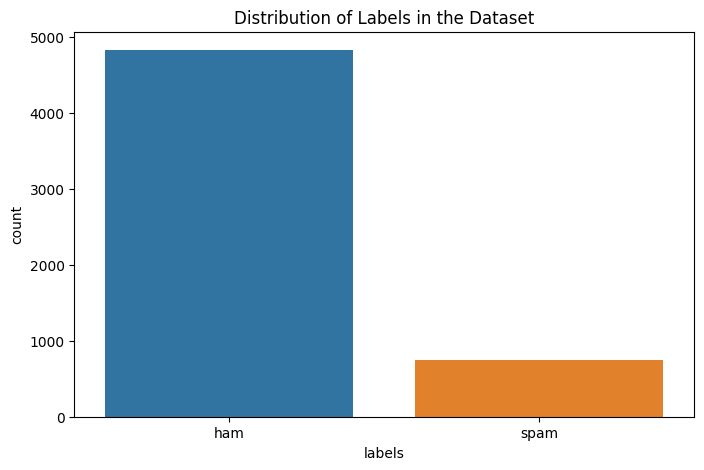

In [16]:
# Plot the distribution of labels in the dataset
plt.figure(figsize=(8, 5))
sns.countplot(x='labels', data=df)
plt.title('Distribution of Labels in the Dataset')
plt.show()

In [17]:
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [18]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [19]:
y = df['b_labels'].values

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [21]:
max_vocab_size = 20000
tokenizer = Tokenizer(num_words = max_vocab_size)


In [22]:
tokenizer.fit_on_texts(x_train)

In [23]:
sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

In [24]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are: %s' % V)

Total number of unique tokens are: 7346


In [25]:
# Pad sequences for consistent input length
data_train = pad_sequences(sequence_train)
print(data_train)

[[   0    0    0 ...  268  649  131]
 [   0    0    0 ... 3470 3471 3472]
 [   0    0    0 ...   19    5  336]
 ...
 [   0    0    0 ...  505   10   62]
 [   0    0    0 ...   66 3133   75]
 [   0    0    0 ...  106   77  153]]


In [26]:
len(data_train[0])

189

In [27]:
len(data_train[1])

189

In [28]:
T = data_train.shape[1]

In [29]:
print(T)

189


In [30]:
data_test = pad_sequences(sequence_test, maxlen=T)

In [31]:
print(T)

189


In [32]:
print(data_test.shape)

(1839, 189)


# Define model architecture

In [33]:
D = 20
i = Input(shape=(T,))

In [34]:
x= Embedding(V+1, D)(i)

In [35]:
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPool1D(3)(x)

x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPool1D(3)(x)

x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)

x= Dense(1, activation='sigmoid')(x)
model = Model(i, x)

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Train the model
r = model.fit(x = data_train, y = y_train, epochs=5, validation_data = (data_test, y_test))

Epoch 1/5
117/117 [==============================] - 4s 20ms/step - loss: 0.3955 - accuracy: 0.8647 - val_loss: 0.2708 - val_accuracy: 0.8679
Epoch 2/5
117/117 [==============================] - 3s 22ms/step - loss: 0.1235 - accuracy: 0.9512 - val_loss: 0.0647 - val_accuracy: 0.9793
Epoch 3/5
117/117 [==============================] - 3s 30ms/step - loss: 0.0194 - accuracy: 0.9952 - val_loss: 0.0677 - val_accuracy: 0.9788
Epoch 4/5
117/117 [==============================] - 2s 20ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0714 - val_accuracy: 0.9815
Epoch 5/5
117/117 [==============================] - 2s 18ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0717 - val_accuracy: 0.9842



# Plot training and validation loss

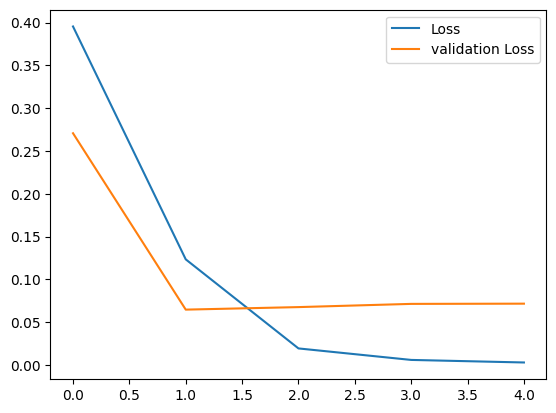

In [38]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy

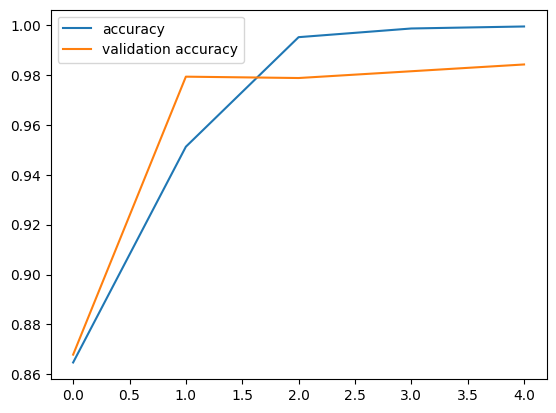

In [39]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

58/58 [==============================] - 0s 6ms/step


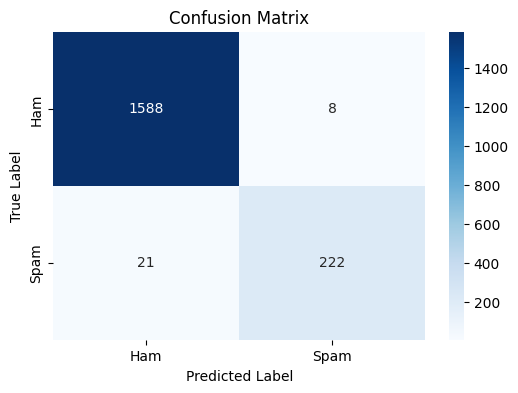

In [40]:
# Plot the confusion matrix
y_pred = model.predict(data_test).round().astype(int)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# Plot the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1596
           1       0.97      0.91      0.94       243

    accuracy                           0.98      1839
   macro avg       0.98      0.95      0.96      1839
weighted avg       0.98      0.98      0.98      1839



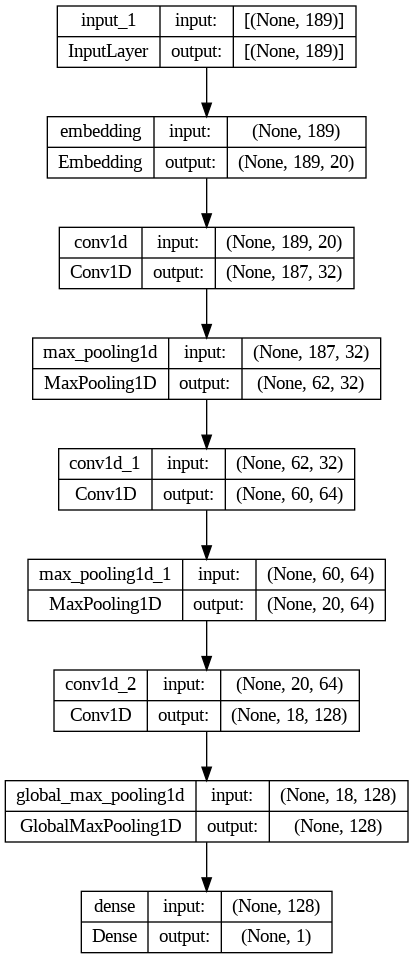

In [42]:
# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')